# Worksheet 5: Thresholds and climate extremes
The following exercises demonstrate analysis of moderate extremes in climate simulated using PRECIS. As with the other worksheets, these are just examples of some of the analysis that you might perform using packages such as Python and and the python Library IRIS.

The basis of climate extremes analysis is a common set of standard extreme climate indices, defined by the World Climate Research Programme [Expert Team on Climate Change Detection and Indices (ETCCDI)](https://www.wcrp-climate.org/etccdi).

There are 27 climate extremes indices, nicely summarised by the [Climdex](https://www.climdex.org/learn/indices/) website.  You can read more about them in the frame below...

In [46]:
from IPython.display import IFrame
IFrame('https://www.climdex.org/learn/indices/', width=950, height=350)

In this worksheet we'll be looking at wet days, a threshold measure giving the count of days when $\mathrm{pr} \geq 1 mm \;day^{-1}$, and **R95p**, the 95th percentile of precipitation on wet days ($\mathrm{pr} \geq 1 mm \;day^{-1}$) in the 1961-1990 period.

<div class="alert alert-block alert-warning">
<b>By the end of this worksheet you should be able to:</b><br> 
- Have an appreciation for working with daily model data <br>
- Understand how to calculate some useful climate extremes statistics<br>
- Be aware of some coding stratagies for dealing with large data sets<br>
</div>

## Contents
### [5.1: Frequency of Wet days](#5.1) 
### [5.2: Calculating percentiles](#5.2)

## Preamble

In [6]:
# Code preamble - these libraries will be used in this worksheet.
# This code block needs to be re-run every time you restart this worksheet!
%matplotlib inline 
import os
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import dask
dask.config.set(scheduler=dask.get)
import dask.array as da
from iris.analysis import Aggregator

# Some helpful data locations
DATADIR = '/project/precis/worksheets/data'
CLIMDIR = os.path.join(DATADIR, 'climatology')
HISTDIR = os.path.join(DATADIR, 'historical')
FUTRDIR = os.path.join(DATADIR, 'future')
APHRODIR = os.path.join(DATADIR, 'APHRODITE')
CRUDIR = os.path.join(DATADIR, 'CRU')
JOBIDS = ['cahpa', 'cahpb']
TIME_PERIODS = {'historical':'1961_1990', 'future':'2021_2050'}

# Some helpful data locations
# DATADIR = '/project/precis/worksheets/data'
# APHRODIR = os.path.join(DATADIR, 'APHRODITE')
# CRUDIR = os.path.join(DATADIR, 'CRU')
# CLIMDIR = os.path.join(DATADIR, 'climatology')
# MODELDIR = os.path.join(DATADIR, 'netcdf')
# JOBIDS = ['cahpa', 'cahpb']
# TIME_PERIODS = {'baseline':'1981_1983', 'future':'2021_2050'}

---
<div class="alert alert-block alert-success">
    <b>Question:</b> Thinking about climate extremes, what model <b>averaging period</b> should we be using for our data analysis? Why? <br>
    How do we identify this model avergaing period in the model output <b>filenames</b>?
</div>

<b>Answer:</b><br>
*Type your answer here...*

---

<a id='5.1'></a>
## 5.1 Frequency of wet days

**a)** Start by finding the frequency of wet days using daily data for both _cahpa_ and _cahpb_.  Calculate the number of days in both the baseline and future periods which are wet days - **a wet day is defined as having precipitation >=1 mm/day**.  Then calculate the percentage of wet days.


In [12]:
# For each day: Is rainfall >= 1? True/False
# Sum over all days to get number of wet days at each grid point
# Do for both model simulations and time periods
# Then calcuate the percentage of wet days.

# Define a new aggregator to help count non-zero days
# (This uses a dask array to reduce memory load)
count_nonzero = Aggregator('count', None,
                           units_func=lambda units: 1,
                           lazy_func=da.count_nonzero)

for runid in JOBIDS:
    for period in TIME_PERIODS.keys():
        # Get path to daily data
        infile = os.path.join(DATADIR, period, runid + '.day.' + TIME_PERIODS[period] + '.pr.*.nc')
        data = iris.load_cube(infile)
        # Select only wet days using our custom aggregator
        model_wetdays = data.collapsed('time', count_nonzero)
        model_wetdays.rename('{} number of wet days (>=1mm/day) {}'.format(runid, TIME_PERIODS[period]))
        # Save the file
        outfile = os.path.join(CLIMDIR, runid + '.day.' + TIME_PERIODS[period] + '.wetday.nc')
        iris.save(model_wetdays, outfile)
        print('Saved: {}'.format(outfile))
        
        # Find wet days as a percentage of total days
        total_days = len(obs.coord('time').points)  # Note that this is a 360 day calendar!
        model_pcent_wetdays = (model_wetdays / total_days) * 100
        # Add metadata
        model_pcent_wetdays.rename('{} percentage of wet days (>=1mm/day) {}'.format(runid, TIME_PERIODS[period]))
        model_pcent_wetdays.units = '%'
        # Save the file
        outfile = os.path.join(CLIMDIR, runid + '.day.' + TIME_PERIODS[period] + '.wetday.pcent.nc')
        iris.save(model_pcent_wetdays, outfile)
        print('Saved: {}'.format(outfile))

Saved: /project/precis/worksheets/data/climatology/cahpa.day.1961_1990.wetday.nc
Saved: /project/precis/worksheets/data/climatology/cahpa.day.1961_1990.wetday.pcent.nc
Saved: /project/precis/worksheets/data/climatology/cahpa.day.2021_2050.wetday.nc
Saved: /project/precis/worksheets/data/climatology/cahpa.day.2021_2050.wetday.pcent.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.1961_1990.wetday.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.1961_1990.wetday.pcent.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.2021_2050.wetday.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.2021_2050.wetday.pcent.nc



**b) Calculate numbers of wet days and percentage of wet days from the _APHRODITE_ observations**. 

[APHRODITE](http://www.chikyu.ac.jp/precip/english/) (_Asian Precipitation - Highly-Resolved Observational Data Integration Towards Evaluation_) is a daily gridded dataset of precipitation and temperature from (1951 onward). It is continental-scale and contains a dense network of daily rain-gauge data for Asia including the Himalayas, South and Southeast Asia and mountainous areas in the Middle East.  

We have extracted APHRODITE data for the period 1961 to 1990. APHRODITE uses a Greogorian 365.25-day calendar (ie. includes leap years), so this data set has 10957 days.

We'll use APHRODITE as our observational data from which to compare our PRECIS model data.

**Fill in the missing code** to calculate the observed wet days: 

In [28]:
# Load APHRODITE daily precipitation data:
infile = os.path.join(APHRODIR, 'aphro.day.1961_1990.nc')
obs = iris.load_cube(infile, 'daily precipitation analysis interpolated onto 0.25deg grids [mm/day]')

# Find number of wet days


# Save wet days cube


# Find number of days in dataset


# Find wet days as percent of all aphro days 


# Save 

# Load APHRODITE daily precipitation data:
infile = os.path.join(APHRODIR, 'aphro.day.1961_1990.nc')
obs = iris.load_cube(infile, 'daily precipitation analysis interpolated onto 0.25deg grids [mm/day]')
# Find number of days in dataset
number_aphro_days = len(obs.coord('time').points)
# Find number of wet days
obs_wetdays = obs.collapsed('time', count_nonzero)
obs_wetdays.rename('Aphrodite number of wet days (>=1mm/day) 1961-1990')
# Save ouput
outfile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
iris.save(obs_wetdays, outfile)
print('Saved: {}'.format(outfile))

# Find wet days percent
obs_pcent_wetdays = (obs_wetdays / number_aphro_days) * 100
obs_pcent_wetdays.rename('Aphrodite percentage of wet days (>=1mm/day) 1961-1990')
obs_pcent_wetdays.units = '%'
outfile = os.path.join(CLIMDIR, 'aphro.wetday.pcent.nc')
iris.save(obs_pcent_wetdays, outfile)
print('Saved: {}'.format(outfile))

/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737

Saved: /project/precis/worksheets/data/climatology/aphro.wetday.nc
Saved: /project/precis/worksheets/data/climatology/aphro.wetday.pcent.nc


---
<div class="alert alert-block alert-success">
    <b>Question:</b> Are there any additional considerations that have to be made with daily data? <br>
    From a coding perspective, how does working with daily data compare to working with monthly data?
</div>

<b>Answer</b><br>
*Type your answer here...*

---

### Plotting

**c)** **Plot** the modelled and observed **numbers of wet days** from 1961-1990. 

/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'cahpa_number_of_wet_days____1mm_day__1961_1990' contains unknown cell method 'count'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'cahpb_numb

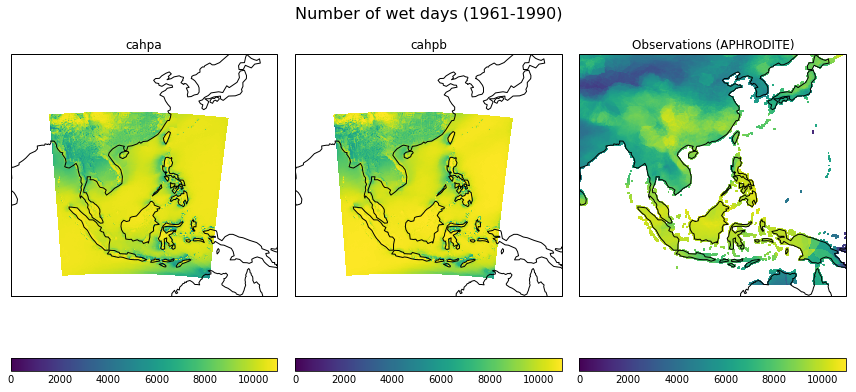

In [25]:
# Plot modelled and observed numbers of wet days for a common baseline period.

# Create a figure of the size 12x12 inches for plots
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Number of wet days (1961-1990)', fontsize=16)

# Set common limits for each subplot
cbar_lims=(0,number_aphro_days)
seasia_domain = [80,150,-15,40]

# Load and plot the models' wet day count
for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, runid + '.day.1961_1990.wetday.nc')
    nwetdays = iris.load_cube(infile)
    ax1 = fig.add_subplot(1, 3, n+1, projection=ccrs.PlateCarree())
    qplt.pcolormesh(nwetdays, vmin=cbar_lims[0], vmax=cbar_lims[1])
    plt.title(runid)
    ax1.coastlines()             # adds coastlines defined by the axes of the plot
    ax1.set_extent(seasia_domain)

# Load and plot APHRODITE wet day count
infile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
obs_nwetdays = iris.load_cube(infile)
fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
qplt.pcolormesh(obs_nwetdays, vmin=cbar_lims[0], vmax=cbar_lims[1])
plt.title('Observations (APHRODITE)')
ax = plt.gca()              # gca function that returns the current axes
ax.coastlines()
ax.set_extent(seasia_domain)
plt.tight_layout()          # automatically adjusts subplot(s) to fit in to the figure area
plt.show()

---
<div class="alert alert-block alert-success">
<b>Question:</b> Which of the following steps are required in order to <b>calculate the model bias</b> (the difference between PRECIS model output and observed data)? <br>
    
* Regrid data onto a common grid, to the finer (higher) resolution <br>
* Regrid data onto a common grid, to the coarser (lower) resolution <br>
* Convert PRECIS output to a regular lat-lon grid if the simulation used a rotated pole <br>
* Ensure the units are comparable (e.g not comparing K with C)  <br>
    
Which of these steps are required when __comparing output for different time periods from the same model simulation__ (e.g. _future - baseline_ difference calculations)? 
</div>    

<b>Answer</b><br>
Steps required to calculate the model bias: <br>
* *type your answer here...*<br>

Steps required when comparing output from the same simulation: <br>
* *type your answer here...*<br>


---

**d)** Calculate the **difference in modelled future and baseline** wet day frequency and also the **difference in modelled baseline and observation** wet day frequency.

In [31]:
# Load percentage of wet days data for the APHRODITE observations
infile = os.path.join(CLIMDIR, 'aphro.wetday.pcent.nc')
obs = iris.load_cube(infile)
# Add coordinate system information to facilitate regridding later
wgs84_cs = iris.coord_systems.GeogCS(6371229.0) 
obs.coord('latitude').coord_system = wgs84_cs 
obs.coord('longitude').coord_system = wgs84_cs

# The observed rainfall data have been created using surface rain gauges, and so are only available
# over land points.  Define a mask to remove sea points. The mask is True for masked points.
mask = np.where(obs.data > 0.0, False, True)

# Redefine the obs data array as a masked array.
obs.data = np.ma.array(obs.data, mask=mask)

# Define regridding method
scheme = iris.analysis.Linear(extrapolation_mode='mask')

for runid in JOBIDS:
    infile = os.path.join(CLIMDIR, runid + '.day.' + TIME_PERIODS['historical'] + '.wetday.pcent.nc')
    model_baseline = iris.load_cube(infile)
    infile = os.path.join(CLIMDIR, runid + '.day.' + TIME_PERIODS['future'] + '.wetday.pcent.nc')
    model_future = iris.load_cube(infile)
    # In order to compare the modelled and observed numbers of wet days,
    # the model data needs to be regridded to the APHRODITE grid
    model_baseline_rg = model_baseline.regrid(obs, scheme)
    model_future_rg = model_future.regrid(obs, scheme)

    # Find the difference between futue and baseline models
    diff_model = model_future_rg - model_baseline_rg
    diff_model.rename('{} change in number of wet days (>=1mm/day) 2021-2050 vs 1961-1990 ')
    # Save the file
    outfile = os.path.join(CLIMDIR, runid + '.wetday.pcent.diff.nc')
    iris.save(diff_model, outfile)
    print('Saved {}'.format(outfile))

    # Subtract the observed percentages of wet days from the modelled percentages
    diff_mod_obs = model_baseline_rg - obs
    diff_mod_obs.rename('{} number of wet days (>=1mm/day) bias compared to Aphrodite'.format(runid))
    # Save the file
    outfile = os.path.join(CLIMDIR, runid + '.wetday.pcent.bias.nc')
    iris.save(diff_mod_obs, outfile)
    print('Saved {}'.format(outfile))

Saved /project/precis/worksheets/data/climatology/cahpa.wetday.pcent.diff.nc
Saved /project/precis/worksheets/data/climatology/cahpa.wetday.pcent.bias.nc
Saved /project/precis/worksheets/data/climatology/cahpb.wetday.pcent.diff.nc
Saved /project/precis/worksheets/data/climatology/cahpb.wetday.pcent.bias.nc


<div class="alert alert-block alert-info">
<b>Note</b>: A cube can be easily constrained to a given domain using the <code>cube.intersection</code> method. More information on this (and other) Iris cube functionality can be found in the <b><a href="https://scitools.org.uk/iris/docs/latest/iris/iris/cube.html?highlight=intersection#iris.cube.Cube.intersection">IRIS Documentation</a></b> online.
</div>

**e)** **Plot the percentage change and model bias for wet day frequency**.  

**First**, run the code block below to produce a series of plots showing the model bias and future precipitation change for _cahpa_ and _cahpb_ simulations. <br>

As the model domain is smaller than the observations domain, you will see that the data is plotted on a domain which is larger than neccessary. 

**Next, read the IRIS documentation** to learn how to use the `cube.intersection` method, then **add the neccessary code** below, to constrain the plots to the model domain.


/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:11

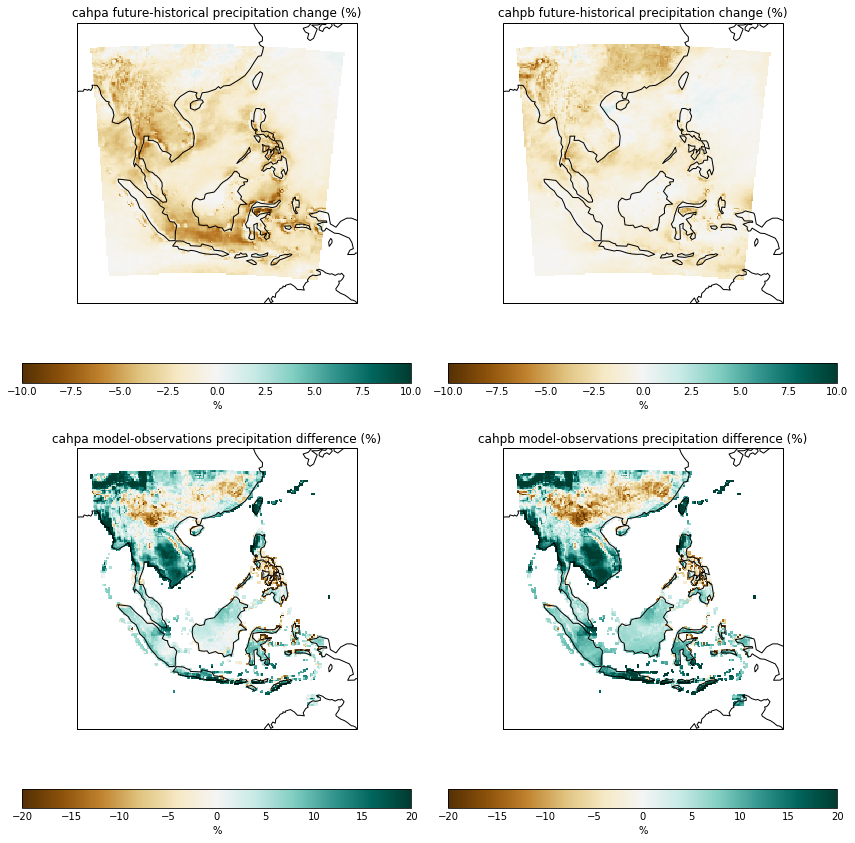

In [38]:
# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))


# Load the model's future percentage change in wet days (future - baseline)
for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, runid + '.wetday.pcent.diff.nc')
    pcent_change = iris.load_cube(infile)
    
    # Add in a line of code to constrain the model domain to these coordinates: 
    # longitude=(90, 137)
    # latitude=(-20, 32)
    pcent_change_subset = pcent_change.intersection(longitude=(90, 137), 
                                                    latitude=(-20, 32))
    
#     pcent_change_subset = pcent_change
    # plot percentage changes on first row
    plt.subplot(2, 2, n+1)
    qplt.pcolormesh(pcent_change_subset, 
                    vmax=10, vmin=-10, cmap='BrBG')
    plt.title(runid + ' future-historical precipitation change (%)')
    ax = plt.gca()
    ax.coastlines()

    
# Load the percentage bias (differences in precipitation between the models and obs)
for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, runid + '.wetday.pcent.bias.nc')
    pcent_bias = iris.load_cube(infile)
    
    # Add in a line of code to constrain the model domain to these lat-lon coordinates: 
    # longitude=(90, 137)
    # latitude=(-20, 32)
    # pcent_bias_subset = ...?...
    pcent_bias_subset = pcent_bias.intersection(longitude=(90, 137), 
                                                    latitude=(-20, 32))
    
    # plot bias on the second row
    plt.subplot(2, 2, n+3)
    qplt.pcolormesh(pcent_bias_subset, 
                    vmax=20, vmin=-20, cmap='BrBG')
    plt.title(runid + ' model-observations precipitation difference (%)')
    ax = plt.gca()
    ax.coastlines()

plt.tight_layout()
plt.show()

---
<div class="alert alert-block alert-success">
    <b>Question:</b><br>

*  Which simulation (<i>cahpa</i> or <i>cahpb</i>) has better agreement with observations for wet day frequency? <br>
* What is the magnitude and location of any notable wet or dry biases for each simulation during the baseline period? <br>
* Summarise the projected change in wet day frequency over South-East Asia for both simiulations. <br>
* Given any wet/dry biases in each simulation's baseline period, what adjustments might we make to our summary of projected change from <i>cahpa</i> or <i>cahpb</i>? 
    </div>

<b>Answers:</b><br>
<i>Which simulation  has better agreement with observations?</i> <br>
* <br>
    
<i>Magnitude and location of any notable wet or dry biases:</i> <br>
* cahpa: <br>
* cahpb: <br>

<i>Summarise the projected change in wet day frequency:</i> <br>
* cahpa: <br>
* cahpb: <br>

<i>Adjustments in light of model bias:</i> <br>
* cahpa: <br>
* cahpb: <br>


---

<a id='5.2'></a>
## 5.2. Calculating percentiles

**f)** Calculate in mm/day the baseline (1961-1990) and future (2021-2050) **95th percentile of precipitation**. Do this for cahpa, cahpb and also for APHRODITE baseline.

This introduces some new processing challenges: **the size of the daily future data set is (probably) too large to load into memory**.  Sometimes Iris can handle this for us (see [Iris and Lazy Data](https://scitools.org.uk/iris/docs/latest/userguide/real_and_lazy_data.html)), but in this case we need to manually **'chunk' the data to load and process smaller sections**.  This way Iris only loads a section of the data at a time and keeps within the memory limits imposed by this computer.

In [52]:
# Specify the number of chunks for the lat and lon dimensions
# This will give us 3 x 3 = 9 cubes
steps = (3, 3)  

# Define a helper function to extract our cube chunks
def chunks(cube, x, y):
    """Yield successive x-y sized chunks from cube"""
    for i in range(0, cube.coord(axis='x').shape[0], x):
        for j in range(0, cube.coord(axis='y').shape[0], y):
            yield cube[:, i:i + x, j:j + y]

Now process the data:

In [50]:
# Loop over job ID and time period
for runid in JOBIDS:
    for period in TIME_PERIODS.keys():
        infile = os.path.join(DATADIR, period, runid + '.day.' + TIME_PERIODS[period] + '.pr.rr.mmday-1.nc')
        model_precip = iris.load_cube(infile)
        # Calculate lat-lon chunks in terms of their index
        lat_chunk = int(model_precip.coord(axis='y').shape[0] / steps[0])
        lon_chunk = int(model_precip.coord(axis='x').shape[0] / steps[1])
        # Make list of cubes
        subcubes = list(chunks(model_precip, lon_chunk, lat_chunk))
        # Loop through subcubes
        model_pc95 = iris.cube.CubeList()
        for cube in subcubes:
            model_pc95.append(cube.collapsed('time', iris.analysis.PERCENTILE, percent=95.))
        # Concetanate the cube list back into one cube
        model_pc95 = model_pc95.concatenate_cube()
        # Give cube a helpful name
        model_pc95.rename('R95p of {} daily rainfall {}'.format(runid, TIME_PERIODS[period]))
        # Save output
        outfile = os.path.join(CLIMDIR, runid + '.day.pc95.' + TIME_PERIODS[period] + '.pr.rr.mmday-1.nc')
        iris.save(model_pc95, outfile)
        print('Saved: {}'.format(outfile))
        # Tidy up memory
        del model_precip, model_pc95

Saved: /project/precis/worksheets/data/climatology/cahpa.day.pc95.1961_1990.pr.rr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpa.day.pc95.2021_2050.pr.rr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.pc95.1961_1990.pr.rr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.pc95.2021_2050.pr.rr.mmday-1.nc


---
<div class="alert alert-block alert-success">
    <b>Question:</b> Why can we only 'chunk' in the lat-lon dimensions?  Why can't we 'chunk' the time dimension?
</div>

<b>Answer</b><br>
<i>Type your answer here...</i>

---

Now do the same for the APHRODITE data:


In [53]:
# Repeat for the APHRODITE data
# Define a mask to remove the sea points, as there are no observations over the sea.
infile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
obs_wetday_no = iris.load_cube(infile)
mask = np.where(obs_wetday_no.data > 0.0, False, True)

infile = os.path.join(APHRODIR, 'aphro.day.1961_1990.nc')
obs_precip = iris.load_cube(infile, 'daily precipitation analysis interpolated onto 0.25deg grids [mm/day]')
# Calculate lat-lon chunks in terms of their index
lat_chunk = int(obs_precip.coord(axis='y').shape[0] / steps[0])
lon_chunk = int(obs_precip.coord(axis='x').shape[0] / steps[1])
# Make list of cubes
subcubes = list(chunks(obs_precip, lon_chunk, lat_chunk))
# Loop through subcubes
obs_pc95 = iris.cube.CubeList()
for cube in subcubes:
    obs_pc95.append(cube.collapsed('time', iris.analysis.PERCENTILE, percent=95.))
# Concetanate the cube list back into one cube
obs_pc95 = obs_pc95.concatenate_cube()
# Redefine the data array of pc95 as a masked array.
obs_pc95.data = np.ma.array(obs_pc95.data, mask=mask)
outfile = os.path.join(CLIMDIR, 'aphro.pc95.1961_1990.mmday-1.nc')
iris.save(obs_pc95, outfile)
print('Saved: {}'.format(outfile))
# Tidy up memory
del obs_precip, obs_pc95

/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'aphrodite_number_of_wet_days____1mm_day__1961_1990' contains unknown cell method 'count'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/c

Saved: /project/precis/worksheets/data/climatology/aphro.pc95.1961_1990.mmday-1.nc



**g)** **Calculate the change in extreme precipitation** _(the difference between the future and baseline 95th percentiles of precipitation)_ **and the associated model bias** _(the difference between the baseline and APHRODITE 95th percentiles of precipitation)._


In [57]:
# Define WGS84 coordinate system
wgs84 = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, inverse_flattening=298.257223563)

# Load aphrodite data
infile = os.path.join(CLIMDIR, 'aphro.pc95.1961_1990.mmday-1.nc')
obs_cube = iris.load_cube(infile)
obs_cube.coord('latitude').coord_system = wgs84 
obs_cube.coord('longitude').coord_system = wgs84

# Define regridding method
scheme = iris.analysis.Linear(extrapolation_mode='mask')

for runid in JOBIDS:
    # First, calculate the difference between the modelled future and baseline 95th percentiles
    infile = os.path.join(CLIMDIR, runid + '.day.pc95.1961_1990.pr.rr.mmday-1.nc')
    model_base = iris.load_cube(infile)
    infile = os.path.join(CLIMDIR, runid + '.day.pc95.2021_2050.pr.rr.mmday-1.nc')
    model_fut = iris.load_cube(infile)
    diff = iris.analysis.maths.subtract(model_fut, model_base)
    diff.rename('{} change in R95p (future - historical)'.format(runid))
    outfile = os.path.join(CLIMDIR, runid + '.day.pc95.diff.pr.mmday-1.nc')
    iris.save(diff, outfile)
    print('Saved: {}'.format(outfile))

    # Next, calculate the differences between the modelled baseline and observed 95th percentiles
    # Remember, to compare the model and observations, the model data need to be regridded.
    model_base_rg = model_base.regrid(obs_cube, scheme)
    bias = obs_cube.copy()
    bias.data = model_base_rg.data - obs_cube.data
    bias.rename('{} bias in R95p (model - obs)'.format(runid))
    outfile = os.path.join(CLIMDIR, runid + '.day.pc95.bias.pr.mmday-1.nc')
    iris.save(bias, outfile)
    print('Saved: {}'.format(outfile))

Saved: /project/precis/worksheets/data/climatology/cahpa.day.pc95.diff.pr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpa.day.pc95.bias.pr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.pc95.diff.pr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.day.pc95.bias.pr.mmday-1.nc


**h)** **Plot the differences in the 95th percentiles** between the models and observations, and the future changes in the 95th percentiles of precipitation from both models.

/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_12_19-2/lib/python3.6/site-packages/iris/co

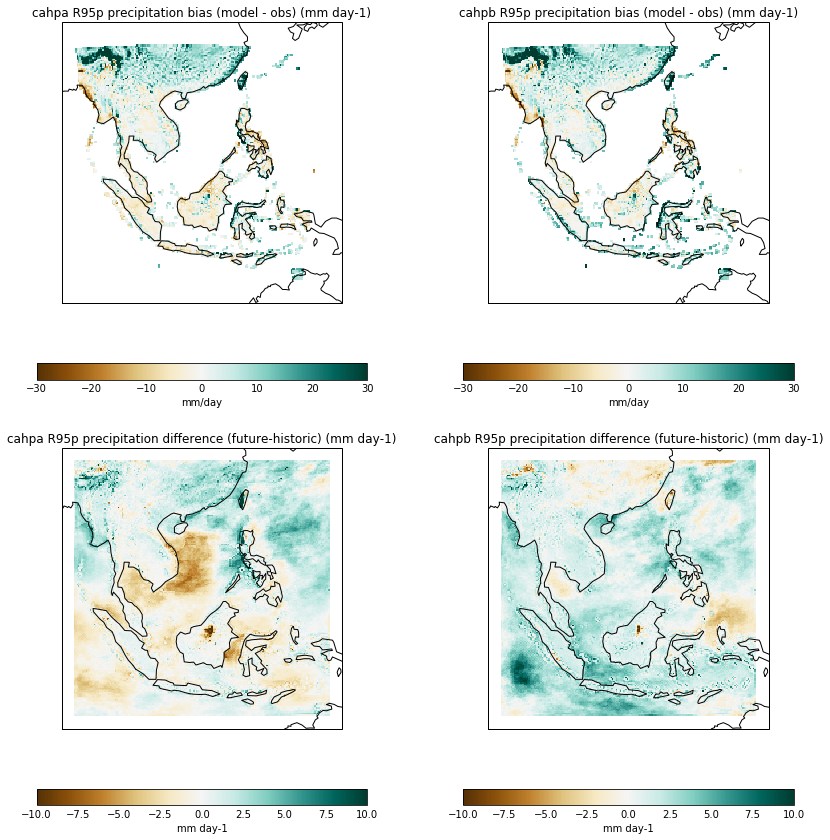

In [61]:
# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))

# Load the 95th percentage differences in precipitation between the models and obs, and plot them.
for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, runid + '.day.pc95.bias.pr.mmday-1.nc')
    pc95_diff = iris.load_cube(infile)
    plt.subplot(2, 2, n+1)
    qplt.pcolormesh(pc95_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), 
                    vmax=30, vmin=-30, cmap='BrBG')
    plt.title('{} R95p precipitation bias (model - obs) (mm day-1)'.format(runid))
    ax = plt.gca()              # gca function that returns the current axes
    ax.coastlines()             # adds coastlines defined by the axes of the plot

    # Load the 95th percentage change in precipitation between future and baseline, plot.
    infile = os.path.join(CLIMDIR, runid + '.day.pc95.diff.pr.mmday-1.nc')
    pc95_diff = iris.load_cube(infile)
    plt.subplot(2, 2, n+3)
    qplt.pcolormesh(pc95_diff, vmax=10, vmin=-10, cmap='BrBG')
    plt.title('{} R95p precipitation difference (future-historic) (mm day-1)'.format(runid))
    ax = plt.gca()      
    ax.coastlines()             

plt.tight_layout()
plt.show()

---
<div class="alert alert-block alert-success">
    <b>Question:</b><br>

* Where do we see the greatest changes in extreme precipitation for each simulation? <br>
* Comment on each model's ability to reprent observed extremes in precipitation at the 95th percentile. <br>
</div>

<b>Answer</b><br>
<i>Greatest changes:</i>
* cahpa: <br>
* cahpb: <br> 

<i>Abilty to represent observed extremes:</i>
* cahpa: <br>
* cahpb: <br> 


---

<center>
<div class="alert alert-block alert-warning">
<b>This completes worksheet 5.</b> <br>You have calculated and compared climate indices for future and baseline rainfall. You have also learned an effective method for working with large quantities of daily data. <br>
In the final worksheet you will combine all the techniques learned to this point, through writing your own code to post-process and analyse PRECIS simulations of extreme temperature over South East Asia. 
</div>
</center>

<center>© Crown Copyright 2019, Met Office</center>